## Classification and Regression Trees (CART)

In [1]:
# Setup Libraries if needed
import pandas as pd
import sklearn
import numpy as np
import matplotlib as mpl
%matplotlib inline
mpl.pyplot.style.use('ggplot')

In [2]:
# import the training data
training = pd.read_csv('../DATA/training.csv', index_col='idx')

# view the data
training.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30to59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60to89DaysPastDueNotWorse,NumberOfDependents
idx,,,,,,,,,,,
1,1,0.766127,45,2,0.802982,9120,13,0,6,0,2
2,0,0.957151,40,0,0.121876,2600,4,0,0,0,1
3,0,0.658180,38,1,0.085113,3042,2,1,0,0,0
4,0,0.233810,30,0,0.036050,3300,5,0,0,0,0
5,0,0.907239,49,1,0.024926,63588,7,0,1,0,0


In [3]:
training.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 1 to 150000
Data columns (total 11 columns):
SeriousDlqin2yrs                         150000 non-null int64
RevolvingUtilizationOfUnsecuredLines     150000 non-null float64
age                                      150000 non-null int64
NumberOfTime30to59DaysPastDueNotWorse    150000 non-null int64
DebtRatio                                150000 non-null float64
MonthlyIncome                            150000 non-null float64
NumberOfOpenCreditLinesAndLoans          150000 non-null int64
NumberOfTimes90DaysLate                  150000 non-null int64
NumberRealEstateLoansOrLines             150000 non-null int64
NumberOfTime60to89DaysPastDueNotWorse    150000 non-null int64
NumberOfDependents                       150000 non-null float64
dtypes: float64(4), int64(7)
memory usage: 13.7 MB


In [4]:
# Import SciKit Learn functions
from sklearn.metrics import roc_curve, auc , roc_auc_score, confusion_matrix, mean_absolute_error
from sklearn.tree import DecisionTreeClassifier , export_graphviz
from sklearn.cross_validation import train_test_split
from sklearn.externals.six import StringIO
from IPython.display import Image


In [5]:
# Split the target from the input variables
X = training.iloc[:, 1:]
y = training.iloc[:, 0]

# Now, split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=1)

In [8]:
# Create a decision tree classifier instance (start out with a small tree for interpretability)
ctree = DecisionTreeClassifier(random_state=1, max_depth=3)

# Fit the decision tree classifier
ctree.fit(X_train, y_train)

# Export graph viz
dotfile = open('tree3.dot', 'w')
export_graphviz(ctree,out_file=dotfile, feature_names=X_train.columns)
dotfile.close()

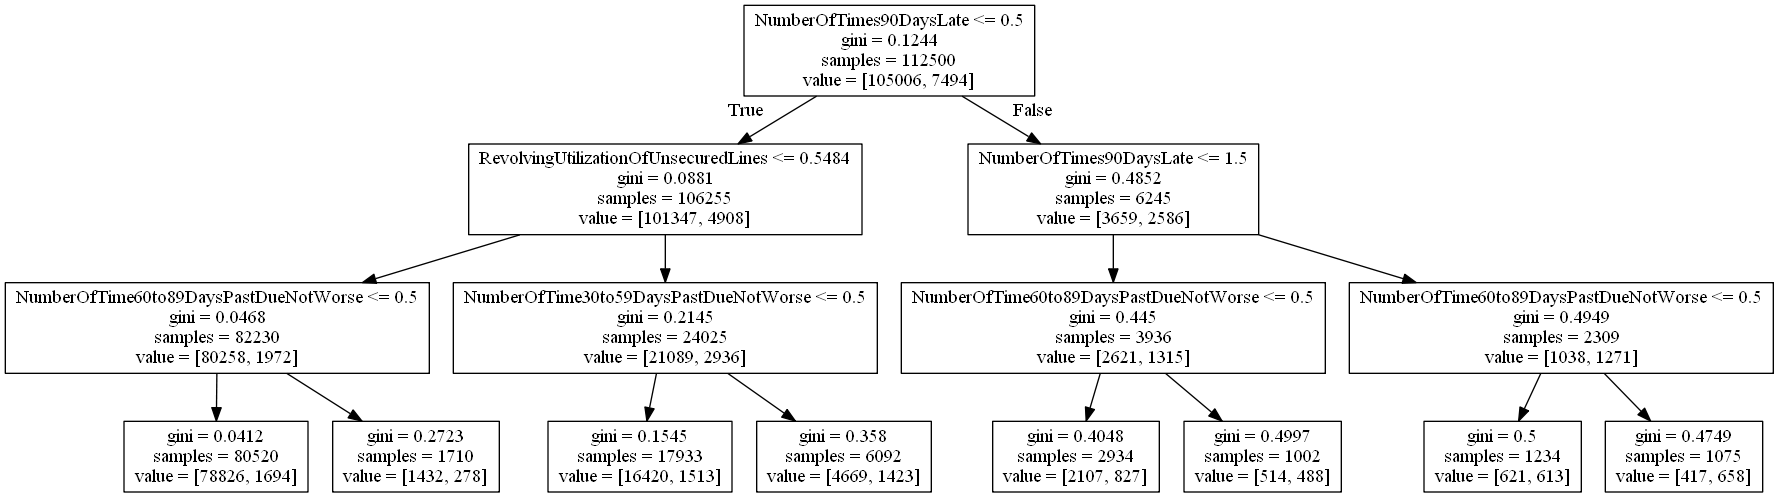

In [10]:
! dot -Tpng tree3.dot -o tree3.png
Image('tree3.png',unconfined=True)

In [8]:
# Create a decision tree classifier instance (Full tree)
ctree2 = DecisionTreeClassifier(random_state=1, criterion='gini')

# Fit the decision tree classifier
ctree2.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=1, splitter='best')

In [9]:
# Export graph viz
dotfile = open('tree2.dot', 'w')
export_graphviz(ctree2,out_file=dotfile, feature_names=X_train.columns)
dotfile.close()
# Already converted the image so commented out now (Big tree so it takes a while)
#! dot -Tpng tree2.dot -o tree2.png 

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.0792134 to fit


In [9]:
# Look at the accuracy metrics
ctree2.predict(X_test)

tree_preds2 = ctree2.predict_proba(X_test)[:, 1]

print "The area under the curve is", roc_auc_score(y_test,tree_preds2)

The area under the curve is 0.614812610889


### Model Evaluation:

As we can see, the Decision tree algorithm (CART) fairs better than that of logistic regression and LDA.
The area under the curve is now approximately 0.61 , which is still a pretty terrible effort, but at least we are headed in the right direction.

Given that the CART method results in highly variable predictions, it may be more worthwhile to progress with a boosted appraoch to the prediction task. 

### But wait.... What about cross validation?? 
Lets try a grid search CV tool to analyse what the best depth of our tree should be in order to make predictions. Then we'll use this to predict in the training set to come up with our AUC measure 

In [10]:
from sklearn import grid_search

In [11]:
parameters = {'max_depth':range(3,20)}
clftree = grid_search.GridSearchCV(DecisionTreeClassifier(random_state=1, criterion='gini'), parameters, n_jobs=4,
                                  scoring='roc_auc',refit=True)
clftree.fit(X_train, y_train)
tree_model = clftree.best_estimator_
print (clftree.best_score_, clftree.best_params_) 

(0.8443632875178112, {'max_depth': 6})


In [12]:

# Now lets predict with depth of 6
ctree = DecisionTreeClassifier(random_state=1, criterion='gini',max_depth=6)

ctree.fit(X_train,y_train)

# Fit the decision tree classifier
ctree.predict(X_test)

tree_preds = ctree.predict_proba(X_test)[:, 1]
# Look at the accuracy metrics
print "The area under the curve is", roc_auc_score(y_test,tree_preds)


The area under the curve is 0.84869198171


## Summary

Wow.. With a pruned tree we've been able to produce a tree that generalised much better to the data. We're now sitting on an ROC of around 0.85. Not bad huh. Lets try some boosting methods to try and get an even better result.

In [13]:
# Predict the test set
# import the test data
test = pd.read_csv('../DATA/test.csv', index_col='idx')

In [14]:
test.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
idx,,,,,,,,,,,
1,NaN,0.885519,43,0,0.177513,5700,4,0,0,0,0
2,NaN,0.463295,57,0,0.527237,9141,15,0,4,0,2
3,NaN,0.043275,59,0,0.687648,5083,12,0,1,0,2
4,NaN,0.280308,38,1,0.925961,3200,7,0,2,0,0
5,NaN,1.000000,27,0,0.019917,3865,4,0,0,0,1


In [15]:
X_ = test.iloc[:, 1:]

In [16]:
X_.head()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
idx,,,,,,,,,,
1,0.885519,43,0,0.177513,5700,4,0,0,0,0
2,0.463295,57,0,0.527237,9141,15,0,4,0,2
3,0.043275,59,0,0.687648,5083,12,0,1,0,2
4,0.280308,38,1,0.925961,3200,7,0,2,0,0
5,1.000000,27,0,0.019917,3865,4,0,0,0,1


In [17]:
# Now lets predict with depth of 6
ctree1 = DecisionTreeClassifier(random_state=1, criterion='gini',max_depth=6)

ctree1.fit(X,y)

# Fit the decision tree classifier
ctree1.predict(X_)

tree_preds = ctree.predict_proba(X_)[:, 1]

tree_preds

array([ 0.08389985,  0.08553971,  0.01089779, ...,  0.01089779,
        0.11017662,  0.03004808])

In [18]:
df = pd.DataFrame(tree_preds)

In [20]:
df.to_csv('../OUTPUT/preds_5.csv')

## Outcome of Private Score Submission: AUC = 0.848429